## Предсказание входящего потока рабочей нагрузки.

В рамках задачи нам необходимо исследовать бизнес-контекст и содержание временного ряда, отражающего количество задач среднего уровня, поступающих в обработку.  

В ТЗ указаны стоимость человеко-часов для сотрудников трех уровней и логика распределения нагрузки по ним:
- при недостаточной нагрузке на специалистов средней квалификации, они направляются на решение задач низкого уровня квалификации 
- при избыточной загрузке к решению задач среднего уровня привлекаются сотрудники с наивысшей категорией  

Таким образом, при недостаточно точном прогнозировании нагрузки мы будем платить штраф в альтернативных издержках:  
- при заниженном прогнозе за каждый человеко-час мы переплачиваем 2 у.е. (5 у.е. за высоковалифицированного сотрудника вместо 3 у.е. за среднеквалифицированного)
- при завышенном прогнозе за каждый человеко-час переплачиваем 1 у.е. (аналогично 3 у.е. вместо 2 у.е. на задачах низкой сложности)  

Исходя из этого мы можем сформулировать метрику, отражающую издержки, сопутствующие следованию прогнозу модели:  
$$metric(y,\hat{y}) = 2 \times\sum_{i:y_i-\hat{y_i}>0}(y_i-\hat{y_i}) +\sum_{j:y_j-\hat{y_j}<0}({\hat{y_j}-y_j}) $$

По метрике, рассчитанной на валидационной выборке, мы сможем определить наиболее удачную модель.


### Предобработка.
Исходные данные представляют из себя временной ряд с годовой историей нагрузки. Данные указаны за рабочие дни.  
В первую очередь нам следует избавиться от аномалий: 
- в один из периодов высокой нагрузки есть аномально высокие значения, не повторяющиеся далее
- в начале наблюдений аномально низкие значения. Это может быть вызвано недостаточным качеством фиксирования потока нагрузки, либо началом работы команды по обработке задач; так или иначе, это может внести большую ошибку в наши модели.

In [55]:
import sys
import warnings
from tqdm import tqdm
from itertools import product

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import catboost as cat

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
%matplotlib inline

In [30]:
# Открываем данные
dataset = pd.read_excel('./Данные проект 2.xlsx', index_col='date')

In [31]:
def bus_metric(y_true, y_pred):
    dif = y_pred-y_true
    dif[dif<0] = np.abs(dif[dif<0]*2)
    return dif.sum()

def bus_MSE(y_true, y_pred):
    dif = y_pred-y_true
    dif[dif<0] = np.abs(dif[dif<0]*2)
    return (dif**2).sum()

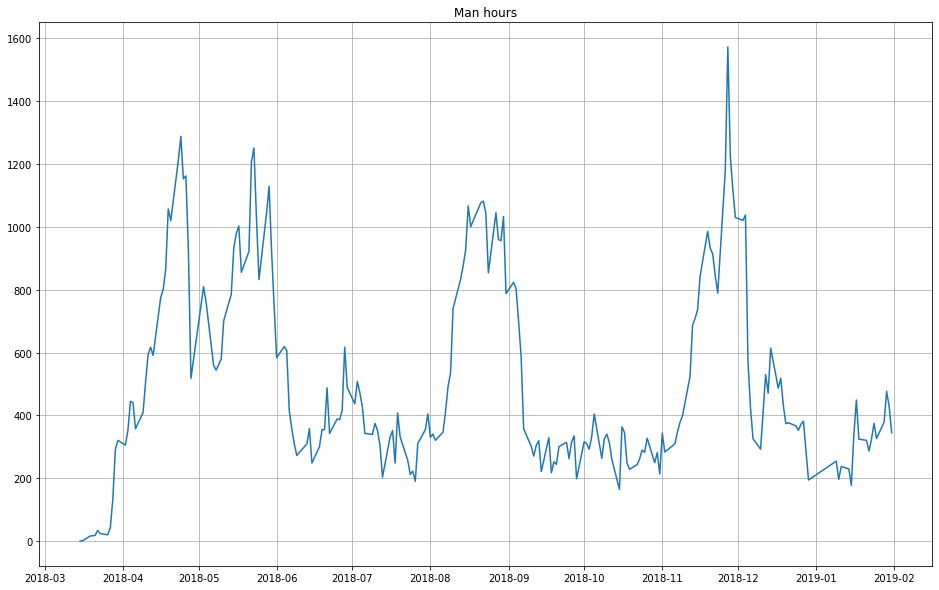

In [32]:
# Посмотрим на график с исходными данными
plt.figure(figsize=(16,10))
plt.plot(dataset['manHours'])
plt.grid()
plt.title('Man hours')
plt.show()

Предположим, что всё то, что находится между 5 и 95 квантилями - хорошие данные. Всё остальное - выбросы.

In [5]:
# Находим квантили
lower_bound = dataset['manHours'].quantile(0.05)
higher_bound = dataset['manHours'].quantile(0.95)

# Рубим квантили
new_df = dataset[(dataset['manHours'] > lower_bound.item()) & (dataset['manHours'] < higher_bound.item())]

Посмотрим, что у нас получилось

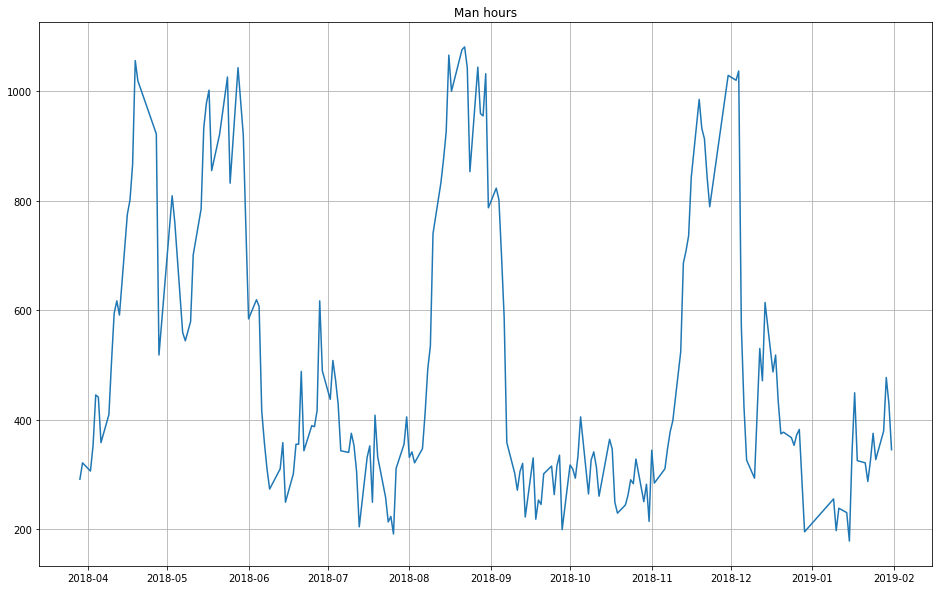

In [6]:
plt.figure(figsize=(16,10))
plt.plot(new_df['manHours'])
plt.grid()
plt.title('Man hours')
plt.show()

Попробуем воспользоваться тройным экспоненциальным сглаживанием или, что то же самое, методом Хольта-Винтерса.

In [33]:
class HoltWinters:
    
    """
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                
                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                
            
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])


            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
                
                
                
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [34]:
def timeseriesCVscore(x):
    # вектор ошибок
    errors = []
    
    values = data.values
    alpha, beta, gamma = x
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 5*4, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))

In [44]:
%%time
data = new_df.manHours[:-20] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 1] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.08765473929168316 0.019333758474110674 0.6219942849640114
Wall time: 2.98 s


In [46]:
# Передаем оптимальные значения модели, 
data = dataset.manHours
model = HoltWinters(data[:-20], slen = 5*4, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 5, scaling_factor = 2.56)
model.triple_exponential_smoothing()

In [47]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    print('metric %f' % bus_metric(data.values, model.result))
    plt.axvspan(len(data)-20, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

In [48]:
plotHoltWinters()

ValueError: operands could not be broadcast together with shapes (220,) (205,) 

In [49]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])


        plt.tight_layout()
    return

Критерий Дики-Фуллера: p=0.056995


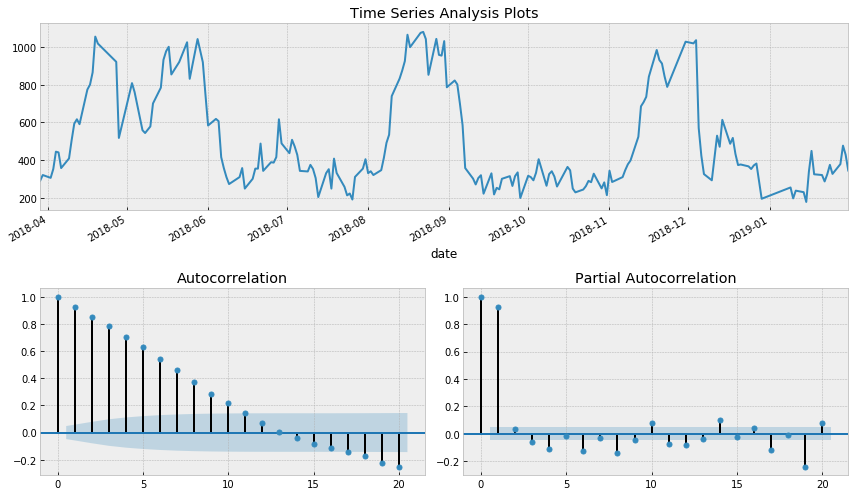

In [50]:
tsplot(new_df.manHours, lags=20)

Критерий Дики-Фуллера: p=0.044640
Оптимальный параметр преобразования Бокса-Кокса: -0.469166


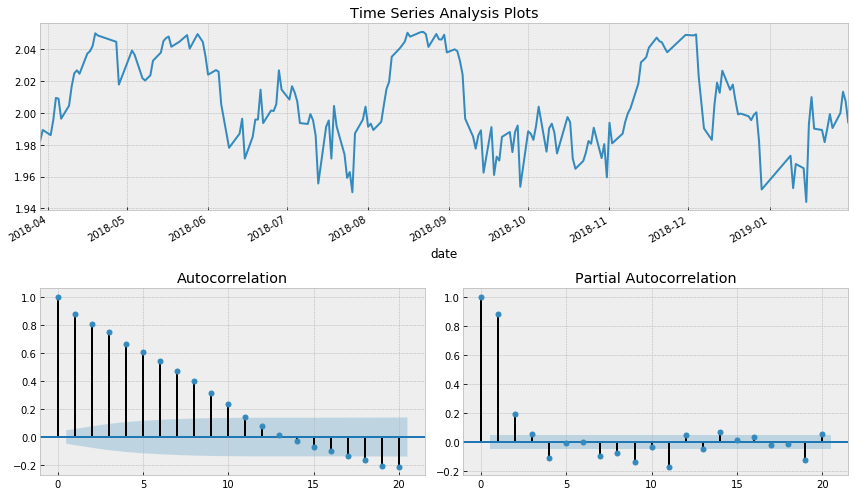

In [51]:
def invboxcox(y,lmbda):
    # обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))


data = new_df.copy()
data['manHours_box'], lmbda = scs.boxcox(data.manHours) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.manHours_box, lags=20)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера: p=0.000000


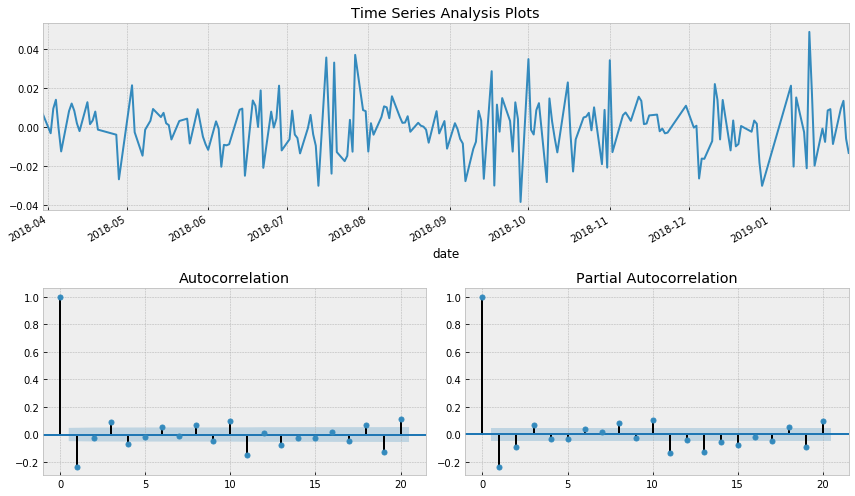

In [52]:
data['manHours_season'] = data.manHours_box - data.manHours_box.shift(1)
tsplot(data.manHours_season[1:].dropna(), lags=20)

D = 1
p = 3
q = 3

Критерий Дики-Фуллера: p=0.000000


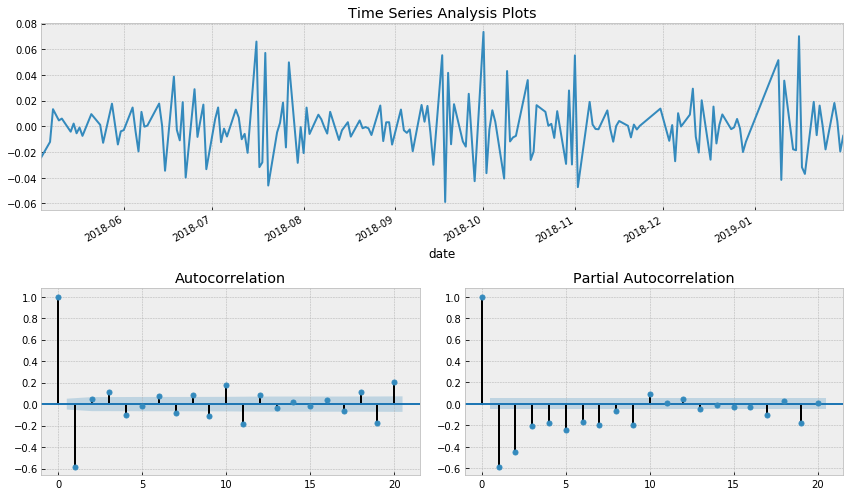

In [53]:
data['manHours_season_diff'] = data.manHours_season - data.manHours_season.shift(1)
tsplot(data.manHours_season_diff[20:].dropna(), lags=20)

In [56]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 1)



parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [57]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.manHours_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[3], D, param[3], 30)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

KeyboardInterrupt: 

In [ ]:
%%time
best_model=sm.tsa.statespace.SARIMAX(data.manHours_box, order=(3, d, 3), 
                                        seasonal_order=(3, D, 1, 30)).fit(disp=-1)

In [ ]:
tsplot(best_model.resid[5:], lags=20)

In [ ]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+30), lmbda)
forecast = data.arima_model.append(forecast).values
actual = data.manHours.values
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
print(bus_metric(actual[35:], forecast[35:198]))
plt.title("SARIMA model\n Mean absolute error {} users".format(round(bus_metric(data.dropna().manHours, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

In [ ]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [ ]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [ ]:
data = pd.DataFrame(new_df.copy())

#data.index = data.index.to_datetime()
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

In [ ]:
code_mean(data, 'weekday', "manHours")

In [ ]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    
    # # Добавили значение дня недели
    # data['date'] = data.index
    # data['weekday'] = data['date'].dt.weekday

    # # Закодируем это дело в OneHot и присоединим
    # one = OneHotEncoder(sparse=False)

    # tmp = pd.DataFrame(one.fit_transform(data.drop(['date', 'y'], axis=1)))
    # tmp.index = data.index
    # data = pd.concat([data.drop(['weekday', 'date'], axis=1), tmp],axis=1)
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    #data.index = data.index.to_datetime()
    data["weekday"] = data.index.weekday
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))

    # выкидываем закодированные средними признаки 
    data.drop(["weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = prepareData(new_df.manHours, test_size=0.3, lag_start=12, lag_end=48)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(bus_metric(prediction, y_test))))
plt.grid(True);